## 😃😶😤SentimentaX: Sentiment Analyzer
#### It is an advanced machine learning application designed to accurately identify and classify various types of texts either positive, negative or neutral. It is trained on reddit dataset and uses LSTM model at its backend.

In [1]:
# Importing Libraries
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
sns.set(style="darkgrid")
%matplotlib inline

import re
import string
from nltk.corpus import stopwords
from wordcloud import WordCloud, STOPWORDS
from collections import Counter
import tensorflow as tf

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import f1_score, precision_score, recall_score
import pickle

import warnings
warnings.filterwarnings("ignore")

In [2]:
# Utility Functions
def text_cleaning(text):
    """
    Clean the text using NLP and regular expressions
    
    text = Uncleaned text
    """
    text = re.sub(r'https?://\S+|www\.\S+', 'URL', text)
    text = re.sub(r'<.*?>', '', text)
    text = ''.join([char for char in text if char in string.printable])
    text = re.sub(r'@\S+', 'USER', text)
    table = str.maketrans('', '', string.punctuation)
    text = text.translate(table)
    text = ' '.join([word for word in text.split() if word not in stopwords.words("english")])
    return text


---
### Data Inspection

In [3]:
# Fetching reddit data
data = pd.read_csv("Reddit_Data.csv")
# Renaming column
data.rename({'clean_comment':'clean_text'}, axis=1, inplace=True)
data.head()

,clean_text,category
0,family mormon have never tried explain them t...,1
1,buddhism has very much lot compatible with chr...,1
2,seriously don say thing first all they won get...,-1
3,what you have learned yours and only yours wha...,0
4,for your own benefit you may want read living ...,1


In [4]:
# Checking datatypes/shape of data
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 37249 entries, 0 to 37248
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   clean_text  37149 non-null  object
 1   category    37249 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 582.1+ KB


In [5]:
# Checking Statistical Summary of data
data.describe(include='all')

,clean_text,category
count,37149,37249.000000
unique,36799,NaN
top,,NaN
freq,115,NaN
mean,NaN,0.202771
std,NaN,0.778515
min,NaN,-1.000000
25%,NaN,0.000000
50%,NaN,0.000000
75%,NaN,1.000000


---
### Data Cleaning

In [6]:
# Checking null values
print(data.isnull().sum())
print()
# Removing null values
data.dropna(inplace=True)
print(data.isnull().sum())

clean_text    100
category        0
dtype: int64

clean_text    0
category      0
dtype: int64


In [7]:
# Checking duplicated values
print(data.duplicated().sum())
print()
# Removing duplicated values
data.drop_duplicates(inplace=True)
data.duplicated().sum()

350



0

In [8]:
# Cleaning text using NLP/Regular expression techniques i.e., # Removing URLs, Removing tags, Removing non-ASCII characters, Removing mentions (@username), Removing all punctuations, Removing English stopwords
data["clean_text"] = data["clean_text"].apply(text_cleaning)
data.head()

,clean_text,category
0,family mormon never tried explain still stare ...,1
1,buddhism much lot compatible christianity espe...,1
2,seriously say thing first get complex explain ...,-1
3,learned want teach different focus goal wrappi...,0
4,benefit may want read living buddha living chr...,1


In [9]:
# Renaming the category for meaningful insights
mapping = {0: 'Neutral', 1: 'Positive', -1: 'Negative'}
data['category'] = data['category'].map(mapping)
data.head()

,clean_text,category
0,family mormon never tried explain still stare ...,Positive
1,buddhism much lot compatible christianity espe...,Positive
2,seriously say thing first get complex explain ...,Negative
3,learned want teach different focus goal wrappi...,Neutral
4,benefit may want read living buddha living chr...,Positive


---
### Exploratory Data Analysis

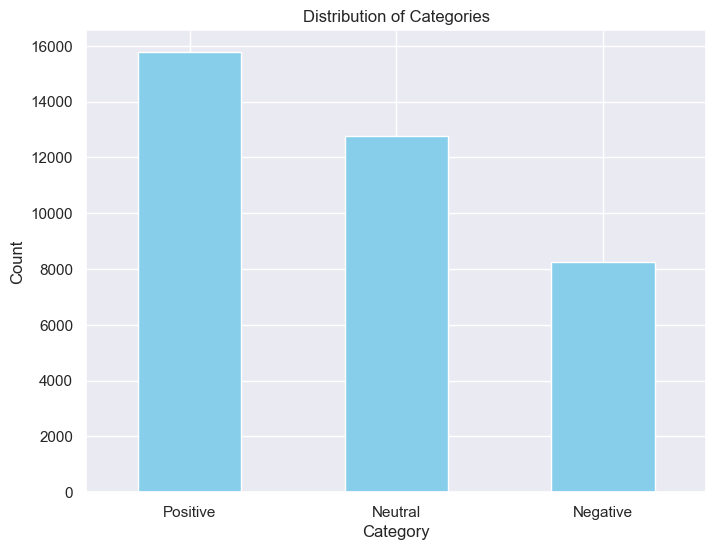

In [10]:
# Checking the distribution of categories
category_counts = data['category'].value_counts()
plt.figure(figsize=(8, 6))
category_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Categories')
plt.xlabel('Category')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

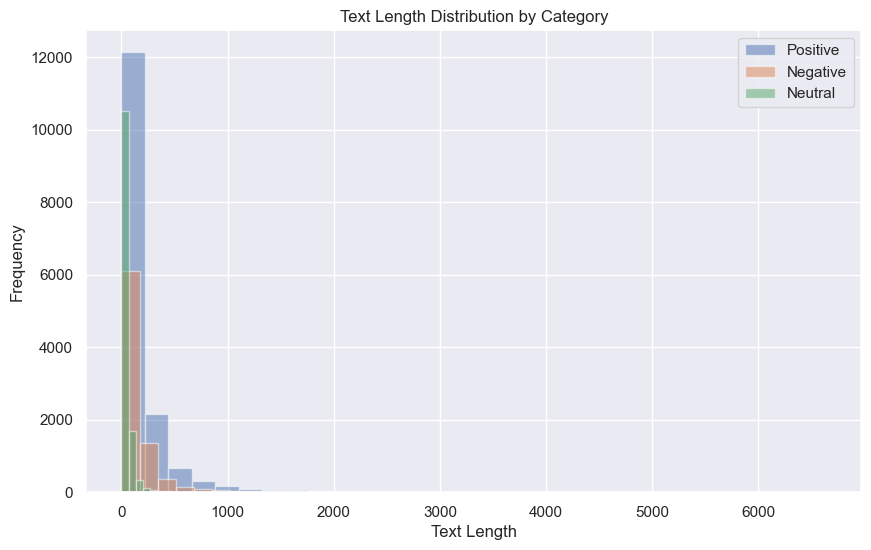

In [11]:
# Performing Text Length Analysis
data['text_length'] = data['clean_text'].apply(len)
plt.figure(figsize=(10, 6))
for category in data['category'].unique():
    subset = data[data['category'] == category]
    plt.hist(subset['text_length'], bins=30, alpha=0.5, label=category)
plt.title('Text Length Distribution by Category')
plt.xlabel('Text Length')
plt.ylabel('Frequency')
plt.legend()
plt.show()

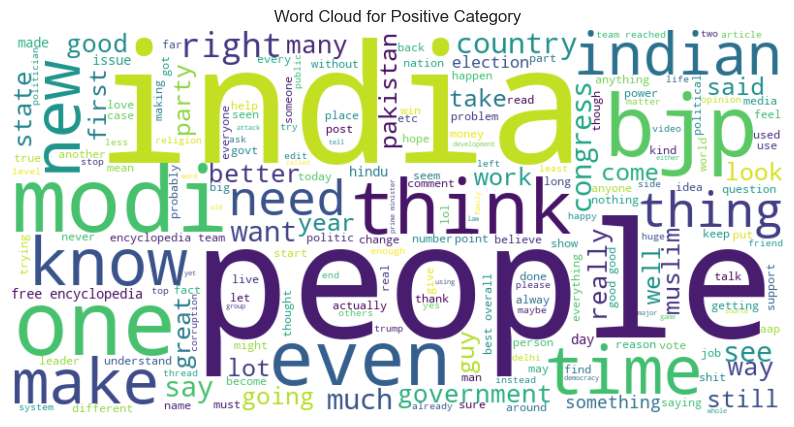

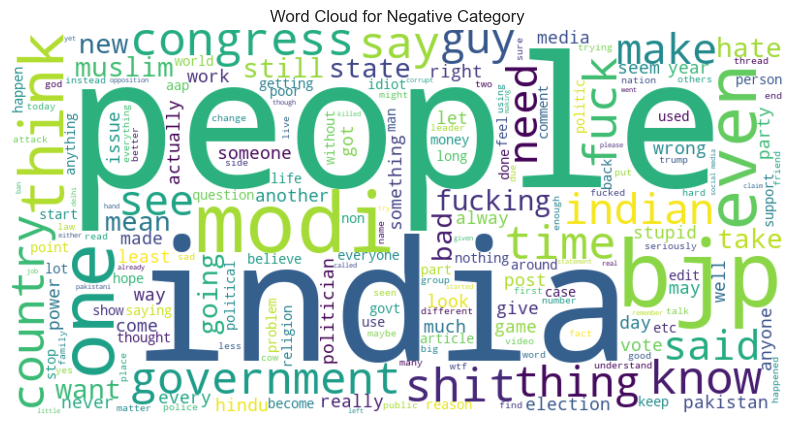

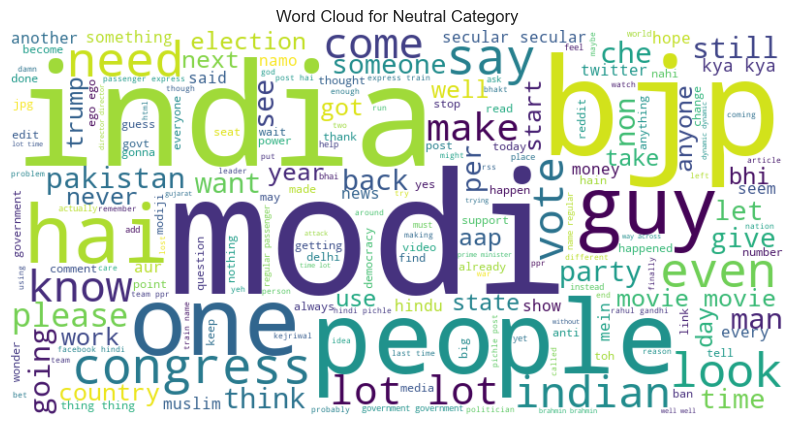

In [12]:
# Creating wordcloud for each category
categories = data['category'].unique()
for category in categories:
    text = " ".join(data[data['category'] == category]['clean_text'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for {category} Category')
    plt.axis("off")
    plt.show()

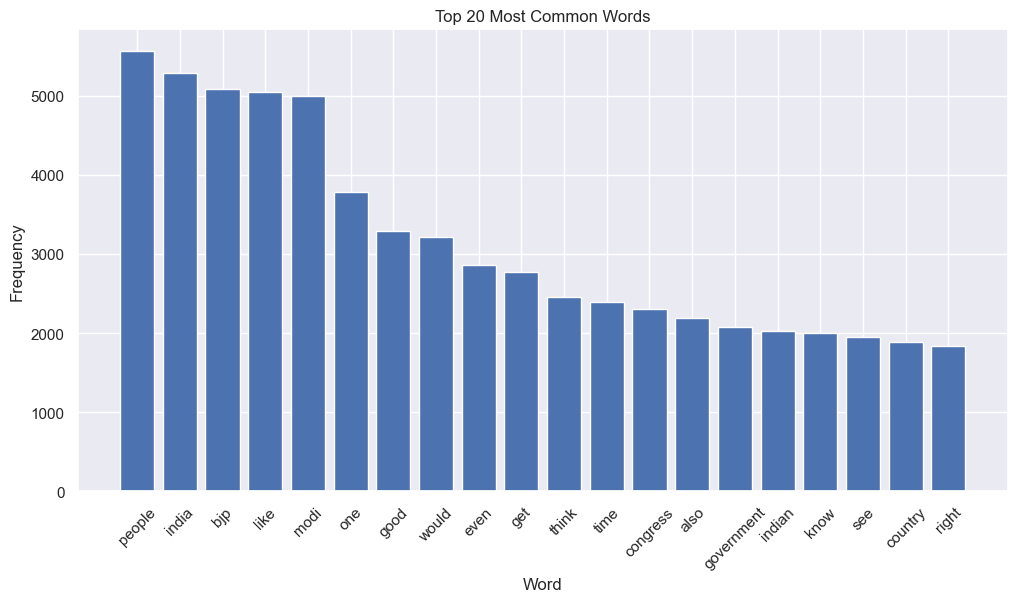

In [13]:
# Calculating Word Frequency 
all_text = " ".join(data['clean_text'])
words = all_text.split()
word_counts = Counter(words)
stopwords = set(STOPWORDS)
top_words = word_counts.most_common(20)
plt.figure(figsize=(12, 6))
plt.bar(*zip(*top_words))
plt.title('Top 20 Most Common Words')
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.xticks(rotation=45)
plt.show()

---
### Data Preprocessing

In [14]:
# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data['clean_text'], data['category'], test_size=0.2, random_state=42)

In [15]:
# Encoding the target labels
label_encoder = LabelEncoder()
y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)
# Checking the mapping
class_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))
print("Class Mapping:")
for class_label, encoded_value in class_mapping.items():
    print(f"{class_label}: {encoded_value}")

Class Mapping:
Negative: 0
Neutral: 1
Positive: 2


In [30]:

# Tokenizing and padding the text data
max_words = 10000  
max_sequence_length = 100  
tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(X_train)
X_train_sequence = tokenizer.texts_to_sequences(X_train)
X_test_sequence = tokenizer.texts_to_sequences(X_test)
X_train_padded = tf.keras.preprocessing.sequence.pad_sequences(X_train_sequence, maxlen=max_sequence_length)
X_test_padded = tf.keras.preprocessing.sequence.pad_sequences(X_test_sequence, maxlen=max_sequence_length)
# Saving the tokenizer for future use
tokenizer_filename = 'tokenizer.pkl'
with open(tokenizer_filename, 'wb') as tokenizer_file:
    pickle.dump(tokenizer, tokenizer_file)

---
### Model Building & Evaluation

In [17]:
# Hyperparameters
embedding_dim = 100
batch_size = 64
epochs = 10
# Building the LSTM model
model = Sequential()
model.add(Embedding(max_words, embedding_dim, input_length=max_sequence_length))
model.add(LSTM(100))
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
# Compiling & training
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
history = model.fit(X_train_padded, y_train, batch_size=batch_size, epochs=epochs, validation_split=0.1)
# Evaluation on Test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test, verbose=1)
print(f'Test Loss: {test_loss:.4f}')
print(f'Test Accuracy: {test_accuracy:.4f}')
# Predictions on Test data
y_test_pred = model.predict(X_test_padded)
y_test_pred_classes = np.argmax(y_test_pred, axis=1)
# Calculate additional metrics
f1 = f1_score(y_test, y_test_pred_classes, average='weighted')
precision = precision_score(y_test, y_test_pred_classes, average='weighted')
recall = recall_score(y_test, y_test_pred_classes, average='weighted')
print(f'F1 Score: {f1:.4f}')
print(f'Precision: {precision:.4f}')
print(f'Recall: {recall:.4f}')

Epoch 1/10
414/414 [==============================] - 44s 101ms/step - loss: 0.6651 - accuracy: 0.7190 - val_loss: 0.4142 - val_accuracy: 0.8485
Epoch 2/10
414/414 [==============================] - 38s 92ms/step - loss: 0.2985 - accuracy: 0.9040 - val_loss: 0.3803 - val_accuracy: 0.8709
Epoch 3/10
414/414 [==============================] - 38s 92ms/step - loss: 0.2158 - accuracy: 0.9362 - val_loss: 0.4154 - val_accuracy: 0.8611
Epoch 4/10
414/414 [==============================] - 42s 102ms/step - loss: 0.1771 - accuracy: 0.9484 - val_loss: 0.4738 - val_accuracy: 0.8638
Epoch 5/10
414/414 [==============================] - 41s 98ms/step - loss: 0.1483 - accuracy: 0.9562 - val_loss: 0.5174 - val_accuracy: 0.8543
Epoch 6/10
414/414 [==============================] - 40s 98ms/step - loss: 0.1231 - accuracy: 0.9646 - val_loss: 0.6225 - val_accuracy: 0.8594
Epoch 7/10
414/414 [==============================] - 40s 96ms/step - loss: 0.1049 - accuracy: 0.9696 - val_loss: 0.6205 - val_accurac

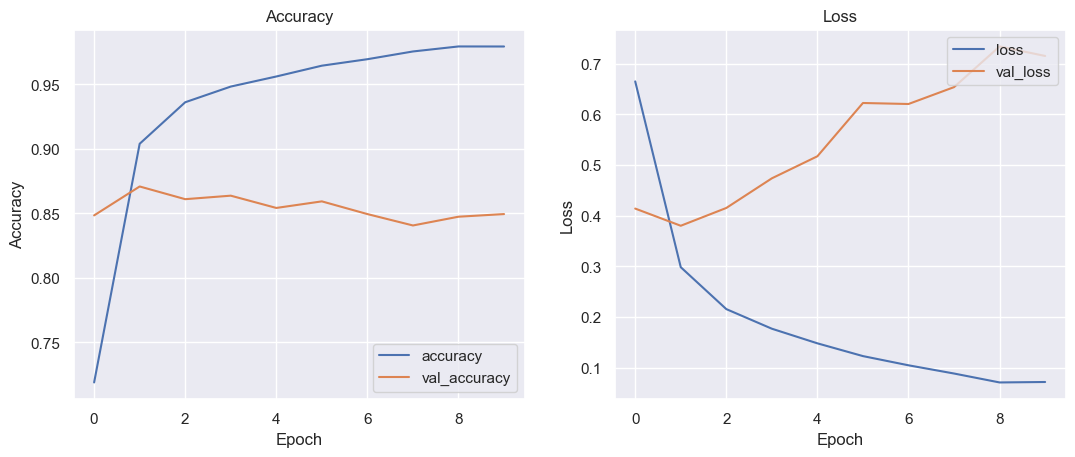

In [18]:
# Plotting training and testing curves
default_size = plt.rcParams['figure.figsize']
fig = plt.figure(figsize=[default_size[0] * 2, default_size[1]])

fig.add_subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label = 'accuracy')         
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')  
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy')
plt.legend(loc='lower right')

fig.add_subplot(1, 2, 2)
plt.plot(history.history['loss'], label='loss')         
plt.plot(history.history['val_loss'], label='val_loss')  
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend(loc='upper right')
plt.show()

In [29]:
user_input = ""
user_sequences = tokenizer.texts_to_sequences([user_input])
user_padded = tf.keras.preprocessing.sequence.pad_sequences(user_sequences, maxlen=max_sequence_length)

from keras.models import load_model
loaded_model = load_model('LSTM.h5')  
class_mapping={
0:'Negative',
1:'Neutral',
2:'Positive'}
# Make predictions on user input
user_predictions = loaded_model.predict(user_padded)
# Convert predictions to class labels (assuming it's a classification task)
user_pred_classes = np.argmax(user_predictions, axis=1)
# Print the predicted class
print(f'Predicted Class: {class_mapping[user_pred_classes[0]]}')


1/1 [==============================] - 0s 316ms/step
Predicted Class: Neutral


---
### Model Saving


In [19]:
# Saving the model to a file
model.save('LSTM.h5')